## GP Classification

We will now briefly discuss GP classification. First, we create a simple XOR dataset (inspired by the code and plots from [scikit-learn example for GP classification](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpc_xor.html)).

In [1]:
import torch
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pyro.contrib.gp as gp
import pyro

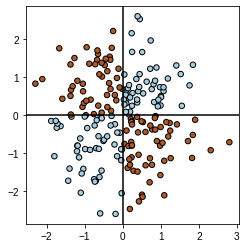

In [2]:
X = torch.randn(200, 2)
y = torch.logical_xor(X[:, 0] > 0, X[:, 1] > 0).double()

plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired, edgecolors=(0, 0, 0))
plt.gca().set_aspect("equal")
plt.axhline(0, color="k")
plt.axvline(0, color="k")

For binary classification, we build on our model from GP regression and use:
$$f \sim \mathcal{GP}\left(0, \mathbf{K}_f(x, x')\right)$$

and use a sigmoid likelihood

$$p(y=+1 \mid f)=\mathrm{Sigmoid}(f)$$

or $$y \sim \mathrm{Bernoulli(Sigmoid(f))}$$

Note, here we wrote $\mathrm{Sigmoid}$ instead of $\sigma$ to prevent confusion.

Given the non-Gaussian likelihood, we use `VariationalGP` as our GP method and `Binary` as likelihood. 

For the interested reader, in implementation, we may sometimes see the above equations written as: `y_dist = dist.Bernoulli(logits=f)` where we can directly specify the `logits`, instead of first applying `sigmoid` and then calling `y_dist = dist.Bernoulli(probs=f)`

In [3]:
kernel = gp.kernels.RBF(input_dim=2)
pyro.clear_param_store()
likelihood = gp.likelihoods.Binary()
model = gp.models.VariationalGP(
    X, y, kernel, likelihood=likelihood, whiten=True, jitter=1e-03
)
num_steps = 1000
loss = gp.util.train(model, num_steps=num_steps)

Text(0, 0.5, 'Loss')

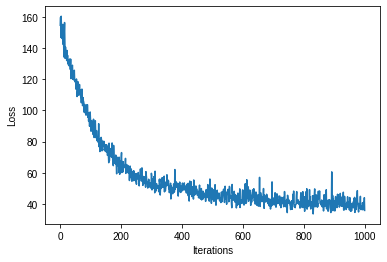

In [4]:
plt.plot(loss)
plt.xlabel("Iterations")
plt.ylabel("Loss")

In [5]:
mean, var = model(X)
y_hat = model.likelihood(mean, var)

print(f"Accuracy: {(y_hat==y).sum()*100/(len(y)) :0.2f}%")

Accuracy: 95.50%


We see that our model did a reasonable job and got a good accuracy on the train data. Let us now visualize the predictions over a 2d grid. 

In [6]:
xs = torch.linspace(-2, 2, steps=100)
ys = torch.linspace(-2, 2, steps=100)

# In newer version we should uncomment the following line
# xx, yy = torch.meshgrid(xs, ys, indexing="xy")

xx, yy = torch.meshgrid(xs, ys)
xx = xx.t()
yy = yy.t()

/home/sachin.yadav/miniconda3/envs/sachin_env/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
with torch.no_grad():
    mean, var = model(torch.vstack((xx.ravel(), yy.ravel())).t())
    Z = model.likelihood(mean, var).reshape(xx.shape)

In [8]:
def plot_pred_2d(arr, xx, yy, contour=False, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    image = ax.imshow(
        arr,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect="equal",
        origin="lower",
        cmap=plt.cm.PuOr_r,
    )
    if contour:
        contours = ax.contour(
            xx,
            yy,
            torch.sigmoid(mean).reshape(xx.shape),
            levels=[0.5],
            linewidths=2,
            colors=["k"],
        )

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    ax.get_figure().colorbar(image, cax=cax)
    if title:
        ax.set_title(title)

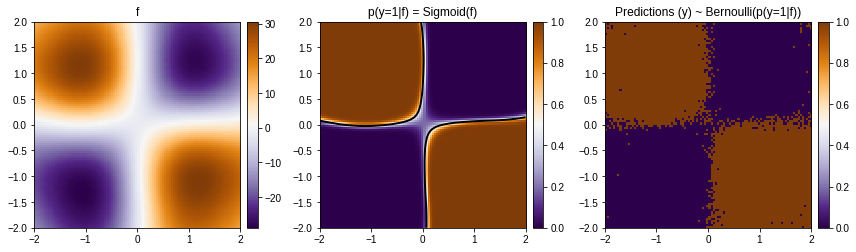

In [9]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
plot_pred_2d(mean.reshape(xx.shape), xx, yy, ax=ax[0], title="f")
plot_pred_2d(
    torch.sigmoid(mean).reshape(xx.shape),
    xx,
    yy,
    ax=ax[1],
    title="p(y=1|f) = Sigmoid(f)",
    contour=True,
)
plot_pred_2d(Z, xx, yy, ax=ax[2], title="Predictions (y) ~ Bernoulli(p(y=1|f))")

fig.tight_layout()